# Mạng máy biến áp

Chào mừng bạn đến với bài tập của Tuần 4, bài tập cuối cùng của Khóa 5 của Chuyên ngành học sâu! Và chúc mừng bạn đã hoàn thành bài tập cuối cùng của toàn bộ Chuyên ngành Học sâu - bạn sắp hoàn thành!

Dễ dàng hơn trong khóa học, bạn đã triển khai các mạng nơ-ron tuần tự như RNN, GRU và LSTM. Trong sổ tay này, bạn sẽ khám phá kiến trúc Transformer, một mạng nơ-ron tận dụng quá trình xử lý song song và cho phép bạn tăng tốc đáng kể quá trình đào tạo.

**Sau nhiệm vụ này, bạn sẽ có thể**:

* Tạo mã hóa vị trí để nắm bắt các mối quan hệ tuần tự trong dữ liệu
* Tính toán sự tự chú ý của sản phẩm chấm theo tỷ lệ bằng cách nhúng từ
* Thực hiện sự chú ý nhiều đầu có mặt nạ
* Xây dựng và đào tạo mô hình Máy biến áp

Lần cuối cùng, chúng ta hãy bắt đầu!

## Table of Contents

- [Packages](#0)
- [1 - Positional Encoding](#1)
    - [1.1 - Sine and Cosine Angles](#1-1)
        - [Exercise 1 - get_angles](#ex-1)
    - [1.2 - Sine and Cosine Positional Encodings](#1-2)
        - [Exercise 2 - positional_encoding](#ex-2)
- [2 - Masking](#2)
    - [2.1 - Padding Mask](#2-1)
    - [2.2 - Look-ahead Mask](#2-2)
- [3 - Self-Attention](#3)
    - [Exercise 3 - scaled_dot_product_attention](#ex-3)
- [4 - Encoder](#4)
    - [4.1 Encoder Layer](#4-1)
        - [Exercise 4 - EncoderLayer](#ex-4)
    - [4.2 - Full Encoder](#4-2)
        - [Exercise 5 - Encoder](#ex-5)
- [5 - Decoder](#5)
    - [5.1 - Decoder Layer](#5-1)
        - [Exercise 6 - DecoderLayer](#ex-6)
    - [5.2 - Full Decoder](#5-2)
        - [Exercise 7 - Decoder](#ex-7)
- [6 - Transformer](#6)
    - [Exercise 8 - Transformer](#ex-8)
- [7 - References](#7)

<a name='0'></a>
## Packages

Run the following cell to load the packages you'll need.

In [ ]:
import tensorflow as tf
import pandas as pd
import time
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.layers import Embedding, MultiHeadAttention, Dense, Input, Dropout, LayerNormalization
from transformers import DistilBertTokenizerFast #, TFDistilBertModel
from transformers import TFDistilBertForTokenClassification
from tqdm import tqdm_notebook as tqdm

<a name='1'> </a>
## 1 - Mã hóa vị trí

Để sắp xếp thứ tự các tác vụ, thứ tự tương đối của dữ liệu của bạn là cực kỳ quan trọng đối với ý nghĩa của nó. Khi bạn đang đào tạo các mạng nơ-ron tuần tự như RNN, bạn đã đưa các đầu vào của mình vào mạng theo thứ tự. Thông tin về thứ tự dữ liệu của bạn đã được tự động đưa vào mô hình của bạn. Tuy nhiên, khi bạn đào tạo mạng Máy biến áp, bạn cung cấp dữ liệu của mình vào mô hình cùng một lúc. Mặc dù điều này làm giảm đáng kể thời gian đào tạo, nhưng không có thông tin về thứ tự dữ liệu của bạn. Đây là lúc mã hóa vị trí rất hữu ích - bạn có thể mã hóa cụ thể vị trí của các đầu vào và chuyển chúng vào mạng bằng cách sử dụng các công thức sin và côsin sau:
$$
PE_{(pos, 2i)}= sin\left(\frac{pos}{{10000}^{\frac{2i}{d}}}\right)
\tag{1}$$
<br>
$$
PE_{(pos, 2i+1)}= cos\left(\frac{pos}{{10000}^{\frac{2i}{d}}}\right)
\tag{2}$$
* $ d $ là kích thước của từ nhúng và mã hóa vị trí
* $ pos $ là vị trí của từ.
* $ i $ đề cập đến từng kích thước khác nhau của mã hóa vị trí.

Các giá trị của phương trình sin và côsin đủ nhỏ (từ -1 đến 1) để khi bạn thêm mã hóa vị trí vào một từ nhúng, từ nhúng không bị bóp méo đáng kể. Tổng của mã hóa vị trí và nhúng từ cuối cùng là những gì được đưa vào mô hình. Sử dụng kết hợp hai phương trình này giúp mạng Máy biến áp của bạn tuân theo các vị trí tương đối của dữ liệu đầu vào của bạn. Lưu ý rằng mặc dù trong bài giảng Andrew sử dụng vectơ dọc nhưng trong bài tập này, tất cả các vectơ đều nằm ngang. Tất cả các phép nhân ma trận cần được điều chỉnh cho phù hợp.

<a name='1-1'> </a>
### 1.1 - Góc sin và góc Cosine

Nhận các góc có thể được sử dụng để tính toán các mã hóa vị trí bằng cách tính toán hạng bên trong của các phương trình sin và cosin:

$$\frac{pos}{10000^{\frac{2i}{d}}} \tag{3}$$

<a name='ex-1'> </a>
### Bài tập 1 - get_Angles()

Triển khai hàm `get_angles()` để tính toán các góc có thể cho các mã hóa vị trí sin và cosin

In [ ]:
# UNQ_C1 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
# GRADED FUNCTION get_angles
def get_angles(pos, i, d):
    """
    Get the angles for the positional encoding
    
    Arguments:
        pos -- Column vector containing the positions [[0], [1], ...,[N-1]]
        i --   Row vector containing the dimension span [[0, 1, 2, ..., M-1]]
        d(integer) -- Encoding size
    
    Returns:
        angles -- (pos, d) numpy array 
    """

    # STATR CODE HERE
    angles = pos / (10000 ** ((2 * (i // 2)) / d))
    # END CODE HERE
    
    return angles

In [ ]:
# UNIT TEST
def get_angles_test(target):
    position = 4
    d_model = 16
    pos_m = np.arange(position)[:, np.newaxis]
    dims = np.arange(d_model)[np.newaxis, :]

    result = target(pos_m, dims, d_model)

    assert type(result) == np.ndarray, "You must return a numpy ndarray"
    assert result.shape == (position, d_model), f"Wrong shape. We expected: ({position}, {d_model})"
    assert np.sum(result[0, :]) == 0
    assert np.isclose(np.sum(result[:, 0]), position * (position - 1) / 2)
    even_cols =  result[:, 0::2]
    odd_cols = result[:,  1::2]
    assert np.all(even_cols == odd_cols), "Submatrices of odd and even columns must be equal"
    limit = (position - 1) / np.power(10000,14.0/16.0)
    assert np.isclose(result[position - 1, d_model -1], limit ), f"Last value must be {limit}"

    print("\033[92mAll tests passed")

get_angles_test(get_angles)

# Example
position = 4
d_model = 8
pos_m = np.arange(position)[:, np.newaxis]
dims = np.arange(d_model)[np.newaxis, :]
get_angles(pos_m, dims, d_model)

All tests passed


array([[0.e+00, 0.e+00, 0.e+00, 0.e+00, 0.e+00, 0.e+00, 0.e+00, 0.e+00],
       [1.e+00, 1.e+00, 1.e-01, 1.e-01, 1.e-02, 1.e-02, 1.e-03, 1.e-03],
       [2.e+00, 2.e+00, 2.e-01, 2.e-01, 2.e-02, 2.e-02, 2.e-03, 2.e-03],
       [3.e+00, 3.e+00, 3.e-01, 3.e-01, 3.e-02, 3.e-02, 3.e-03, 3.e-03]])

<a name='1-2'> </a>
### 1.2 - Mã hóa vị trí sin và Cosine

Bây giờ bạn có thể sử dụng các góc bạn đã tính để tính toán các mã hóa vị trí sin và cosine.
$$
PE_{(pos, 2i)}= sin\left(\frac{pos}{{10000}^{\frac{2i}{d}}}\right)
$$
<br>
$$
PE_{(pos, 2i+1)}= cos\left(\frac{pos}{{10000}^{\frac{2i}{d}}}\right)
$$
<a name='ex-2'> </a>
### Bài tập 2 - mã vị trí

Triển khai hàm `positional_encoding ()` để tính toán các mã hóa vị trí sin và cosine

**Nhắc nhở:** Sử dụng phương trình sin khi $ i $ là số chẵn và phương trình cosin khi $ i $ là số lẻ.

#### Gợi ý bổ sung
* Bạn có thể thấy
[np.newaxis](https://numpy.org/doc/stable/reference/arrays.indexing.html) hữu ích tùy thuộc vào cách triển khai bạn chọn.

In [ ]:
# UNQ_C2 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
# GRADED FUNCTION positional_encoding
def positional_encoding(positions, d):
    """
    Precomputes a matrix with all the positional encodings 
    
    Arguments:
        positions (int) -- Maximum number of positions to be encoded 
        d (int) -- Encoding size 
    
    Returns:
        pos_encoding -- (1, position, d_model) A matrix with the positional encodings
    """
    # START CODE HERE
    # initialize a matrix angle_rads of all the angles 

    angle_rads = get_angles(np.arange(positions)[:, np.newaxis],
                            np.arange(d)[np.newaxis, :],
                            d)
    print(angle_rads.shape)
    # apply sin to even indices in the array; 2i
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
  
    # apply cos to odd indices in the array; 2i+1
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
    # END CODE HERE
    
    pos_encoding = angle_rads[np.newaxis, ...]
    
    return tf.cast(pos_encoding, dtype=tf.float32)

In [ ]:
# UNIT TEST
def positional_encoding_test(target):
    position = 8
    d_model = 16

    pos_encoding = target(position, d_model)
    sin_part = pos_encoding[:, :, 0::2]
    cos_part = pos_encoding[:, :, 1::2]

    assert tf.is_tensor(pos_encoding), "Output is not a tensor"
    assert pos_encoding.shape == (1, position, d_model), f"Wrong shape. We expected: (1, {position}, {d_model})"

    ones = sin_part ** 2  +  cos_part ** 2
    assert np.allclose(ones, np.ones((1, position, d_model // 2))), "Sum of square pairs must be 1 = sin(a)**2 + cos(a)**2"
    
    angs = np.arctan(sin_part / cos_part)
    angs[angs < 0] += np.pi
    angs[sin_part.numpy() < 0] += np.pi
    angs = angs % (2 * np.pi)
    
    pos_m = np.arange(position)[:, np.newaxis]
    dims = np.arange(d_model)[np.newaxis, :]

    trueAngs = get_angles(pos_m, dims, d_model)[:, 0::2] % (2 * np.pi)
    
    assert np.allclose(angs[0], trueAngs), "Did you apply sin and cos to even and odd parts respectively?"
 
    print("\033[92mAll tests passed")

    
positional_encoding_test(positional_encoding)

(8, 16)
All tests passed


Rất tốt khi tính toán các mã hóa vị trí! Bây giờ bạn có thể hình dung chúng.

(50, 512)
(1, 50, 512)


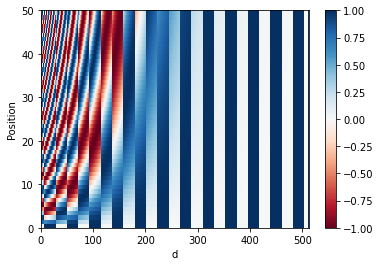

In [ ]:
pos_encoding = positional_encoding(50, 512)

print (pos_encoding.shape)

plt.pcolormesh(pos_encoding[0], cmap='RdBu')
plt.xlabel('d')
plt.xlim((0, 512))
plt.ylabel('Position')
plt.colorbar()
plt.show()

Mỗi hàng đại diện cho một mã hóa vị trí - lưu ý rằng không có hàng nào giống hệt nhau! Bạn đã tạo một mã hóa vị trí duy nhất cho mỗi từ.

<a name='2'> </a>
## 2 - Masking

Có hai loại mặt nạ hữu ích khi xây dựng mạng Máy biến áp của bạn: *padding mask* and the *look-ahead mask*. Cả hai đều giúp tính toán softmax đưa ra trọng số thích hợp cho các từ trong câu đầu vào của bạn.

<a name='2-1'> </a>
### 2.1 - Padding Mask

Thông thường, trình tự đầu vào của bạn sẽ vượt quá độ dài tối đa của trình tự mà mạng của bạn có thể xử lý. Giả sử độ dài tối đa của mô hình của bạn là năm, nó được cung cấp các trình tự sau:

    [["Do", "you", "know", "when", "Jane", "is", "going", "to", "visit", "Africa"], 
     ["Jane", "visits", "Africa", "in", "September" ],
     ["Exciting", "!"]
    ]

có thể được vectơ hóa thành:

    [[ 71, 121, 4, 56, 99, 2344, 345, 1284, 15],
     [ 56, 1285, 15, 181, 545],
     [ 87, 600]
    ]
    
Khi chuyển các chuỗi vào một mô hình máy biến áp, điều quan trọng là chúng phải có chiều dài đồng nhất. Bạn có thể đạt được điều này bằng cách đệm chuỗi bằng các số không và cắt bớt các câu vượt quá độ dài tối đa của mô hình của bạn:

    [[ 71, 121, 4, 56, 99],
     [ 2344, 345, 1284, 15, 0],
     [ 56, 1285, 15, 181, 545],
     [ 87, 600, 0, 0, 0],
    ]
    
Các chuỗi dài hơn độ dài tối đa là năm sẽ bị cắt bớt và các số không sẽ được thêm vào chuỗi bị cắt bớt để đạt được độ dài đồng nhất. Tương tự, đối với các chuỗi ngắn hơn độ dài tối đa, chúng cũng sẽ được thêm các số 0 vào phần đệm. Tuy nhiên, những số không này sẽ ảnh hưởng đến phép tính softmax - đây là lúc mặt nạ đệm có ích! Bằng cách nhân mặt nạ đệm với -1e9 và thêm nó vào chuỗi của bạn, bạn che dấu các số không bằng cách đặt chúng thành gần âm vô cùng. Chúng tôi sẽ thực hiện điều này cho bạn để bạn có thể tận hưởng niềm vui khi xây dựng mạng Máy biến áp! 😇 Chỉ cần đảm bảo bạn xem qua mã để bạn có thể triển khai chính xác phần đệm khi xây dựng mô hình của mình.

Sau khi che, đầu vào của bạn sẽ chuyển từ `[87, 600, 0, 0, 0]` thành `[87, 600, -1e9, -1e9, -1e9]`, để khi bạn lấy softmax, các số không không ảnh hưởng đến điểm số.

In [ ]:
def create_padding_mask(seq):
    """
    Creates a matrix mask for the padding cells
    
    Arguments:
        seq -- (n, m) matrix
    
    Returns:
        mask -- (n, 1, 1, m) binary tensor
    """
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
  
    # add extra dimensions to add the padding
    # to the attention logits.
    return seq[:, tf.newaxis, tf.newaxis, :] 

In [ ]:
x = tf.constant([[7., 6., 0., 0., 1.], [1., 2., 3., 0., 0.], [0., 0., 0., 4., 5.]])
print(create_padding_mask(x))

tf.Tensor(
[[[[0. 0. 1. 1. 0.]]]


 [[[0. 0. 0. 1. 1.]]]


 [[[1. 1. 1. 0. 0.]]]], shape=(3, 1, 1, 5), dtype=float32)


Nếu chúng ta nhân mặt nạ này với -1e9 và thêm nó vào chuỗi đầu vào mẫu, các số không về cơ bản được đặt thành âm vô cùng. Lưu ý sự khác biệt khi lấy softmax của trình tự ban đầu và trình tự bị che:

In [ ]:
print(tf.keras.activations.softmax(x))
print(tf.keras.activations.softmax(x + create_padding_mask(x) * -1.0e9))

tf.Tensor(
[[7.2876632e-01 2.6809818e-01 6.6454883e-04 6.6454883e-04 1.8064311e-03]
 [8.4437370e-02 2.2952460e-01 6.2391245e-01 3.1062772e-02 3.1062772e-02]
 [4.8541022e-03 4.8541022e-03 4.8541022e-03 2.6502502e-01 7.2041267e-01]], shape=(3, 5), dtype=float32)
tf.Tensor(
[[[[7.2973621e-01 2.6845497e-01 0.0000000e+00 0.0000000e+00
    1.8088353e-03]
   [2.4472848e-01 6.6524088e-01 0.0000000e+00 0.0000000e+00
    9.0030566e-02]
   [6.6483547e-03 6.6483547e-03 0.0000000e+00 0.0000000e+00
    9.8670328e-01]]]


 [[[7.3057157e-01 2.6876229e-01 6.6619500e-04 0.0000000e+00
    0.0000000e+00]
   [9.0030566e-02 2.4472848e-01 6.6524088e-01 0.0000000e+00
    0.0000000e+00]
   [3.3333334e-01 3.3333334e-01 3.3333334e-01 0.0000000e+00
    0.0000000e+00]]]


 [[[0.0000000e+00 0.0000000e+00 0.0000000e+00 2.6894143e-01
    7.3105854e-01]
   [0.0000000e+00 0.0000000e+00 0.0000000e+00 5.0000000e-01
    5.0000000e-01]
   [0.0000000e+00 0.0000000e+00 0.0000000e+00 2.6894143e-01
    7.3105854e-01]]]], shape

<a name='2-2'></a>
### 2.2 - Look-ahead Mask
Mặt nạ nhìn trước theo trực giác tương tự. Trong đào tạo, bạn sẽ có quyền truy cập vào đầu ra chính xác hoàn toàn của ví dụ đào tạo của bạn. Mặt nạ nhìn trước giúp mô hình của bạn giả vờ rằng nó đã dự đoán chính xác một phần của kết quả và xem liệu *mà không cần nhìn trước*, nó có thể dự đoán chính xác kết quả tiếp theo hay không.

Ví dụ: nếu đầu ra đúng mong đợi là `[1, 2, 3]` và bạn muốn xem liệu mô hình có dự đoán chính xác giá trị đầu tiên mà nó có thể dự đoán giá trị thứ hai hay không, bạn sẽ bỏ qua giá trị thứ hai và thứ ba. Vì vậy, bạn sẽ nhập chuỗi có mặt nạ `[1, -1e9, -1e9]` và xem liệu nó có thể tạo ra `[1, 2, -1e9]` hay không.

Chỉ vì bạn đã làm việc rất chăm chỉ, chúng tôi cũng sẽ thực hiện mặt nạ này cho bạn 😇😇. Một lần nữa, hãy xem kỹ mã để bạn có thể triển khai nó một cách hiệu quả sau này.

In [ ]:
def create_look_ahead_mask(size):
    """
    Returns an upper triangular matrix filled with ones
    
    Arguments:
        size -- matrix size
    
    Returns:
        mask -- (size, size) tensor
    """
    mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
    return mask 

In [ ]:
x = tf.random.uniform((1, 3))
temp = create_look_ahead_mask(x.shape[1])
temp

<tf.Tensor: shape=(3, 3), dtype=float32, numpy=
array([[0., 1., 1.],
       [0., 0., 1.],
       [0., 0., 0.]], dtype=float32)>

<a name='3'> </a>
## 3 - Tự chú ý

Như các tác giả của tờ báo về Transformers, "Sự chú ý là tất cả những gì bạn cần".


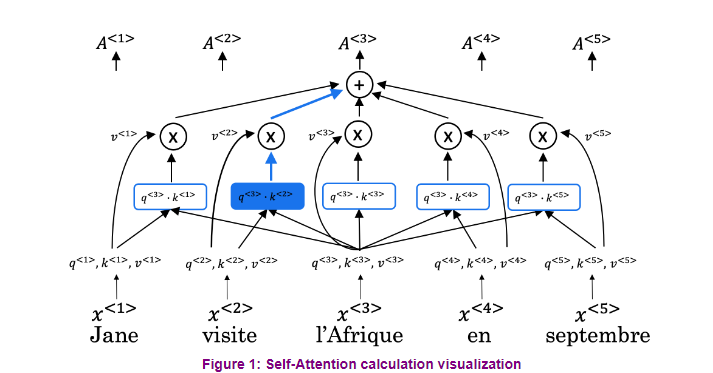

Việc sử dụng sự chú ý của bản thân kết hợp với các mạng tích hợp truyền thống cho phép tạo ra sự song song giúp tăng tốc quá trình đào tạo. Bạn sẽ triển khai **sự chú ý sản phẩm theo tỷ lệ dấu chấm** lấy một truy vấn, khóa, giá trị và mặt nạ làm đầu vào để trả về các biểu diễn vectơ phong phú, dựa trên sự chú ý của các từ trong chuỗi của bạn. Loại tự chú ý này có thể được biểu thị bằng toán học như sau:
$$
\text { Attention }(Q, K, V)=\operatorname{softmax}\left(\frac{Q K^{T}}{\sqrt{d_{k}}}+{M}\right) V\tag{4}\
$$

* $ Q $ là ma trận các truy vấn
* $ K $ là ma trận các khóa
* $ V $ là ma trận các giá trị
* $ M $ là mặt nạ tùy chọn mà bạn chọn để áp dụng
* $ {d_k} $ là kích thước của các phím, được sử dụng để thu nhỏ mọi thứ để softmax không phát nổ

<a name='ex-3'> </a>
### Bài tập 3 - scale_dot_product_attention

  Triển khai hàm `scaled_dot_product_attention ()` để tạo các biểu diễn dựa trên sự chú ý
  
**Nhắc nhở**: Tham số mặt nạ boolean có thể được chuyển vào dưới dạng `none 'hoặc dưới dạng đệm hoặc nhìn về phía trước. Nhân nó với -1e9 trước khi áp dụng softmax.

**Gợi ý bổ sung**
* Bạn có thể thấy [tf.matmul](https://www.tensorflow.org/api_docs/python/tf/linalg/matmul) hữu ích cho phép nhân ma trận.

In [ ]:
# UNQ_C3 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
# GRADED FUNCTION scaled_dot_product_attention
def scaled_dot_product_attention(q, k, v, mask):
    """
    Calculate the attention weights.
      q, k, v must have matching leading dimensions.
      k, v must have matching penultimate dimension, i.e.: seq_len_k = seq_len_v.
      The mask has different shapes depending on its type(padding or look ahead) 
      but it must be broadcastable for addition.

    Arguments:
        q -- query shape == (..., seq_len_q, depth)
        k -- key shape == (..., seq_len_k, depth)
        v -- value shape == (..., seq_len_v, depth_v)
        mask: Float tensor with shape broadcastable 
              to (..., seq_len_q, seq_len_k). Defaults to None.

    Returns:
        output -- attention_weights
    """
    # START CODE HERE

    # Q*K'
    matmul_qk = tf.linalg.matmul(q,k.T)
    print(k.shape[0])
    # scale matmul_qk
    dk = k.shape[0]

    scaled_attention_logits =tf.math.divide(matmul_qk, np.sqrt (dk))

    # add the mask to the scaled tensor.
    if mask is not None:
        scaled_attention_logits += mask*-1e9

    # softmax is normalized on the last axis (seq_len_k) so that the scores
    # add up to 1.
    attention_weights = tf.math.softmax(scaled_attention_logits)  # (..., seq_len_q, seq_len_k)

    # attention_weights * V
    output = tf.linalg.matmul(attention_weights,v)  # (..., seq_len_q, depth_v)

    # END CODE HERE

    return output, attention_weights

In [ ]:
# UNIT TEST
def scaled_dot_product_attention_test(target):
    q = np.array([[1, 0, 1, 1], [0, 1, 1, 1], [1, 0, 0, 1]]).astype(np.float32)
    k = np.array([[1, 1, 0, 1], [1, 0, 1, 1 ], [0, 1, 1, 0], [0, 0, 0, 1]]).astype(np.float32)
    v = np.array([[0, 0], [1, 0], [1, 0], [1, 1]]).astype(np.float32)

    attention, weights = target(q, k, v, None)
    assert tf.is_tensor(weights), "Weights must be a tensor"
    assert tuple(tf.shape(weights).numpy()) == (q.shape[0], k.shape[1]), f"Wrong shape. We expected ({q.shape[0]}, {k.shape[1]})"
    assert np.allclose(weights, [[0.2589478,  0.42693272, 0.15705977, 0.15705977],
                                   [0.2772748,  0.2772748,  0.2772748,  0.16817567],
                                   [0.33620113, 0.33620113, 0.12368149, 0.2039163 ]])

    assert tf.is_tensor(attention), "Output must be a tensor"
    assert tuple(tf.shape(attention).numpy()) == (q.shape[0], v.shape[1]), f"Wrong shape. We expected ({q.shape[0]}, {v.shape[1]})"
    assert np.allclose(attention, [[0.74105227, 0.15705977],
                                   [0.7227253,  0.16817567],
                                   [0.6637989,  0.2039163 ]])

    mask = np.array([0, 0, 1, 0])
    attention, weights = target(q, k, v, mask)

    assert np.allclose(weights, [[0.30719590187072754, 0.5064803957939148, 0.0, 0.18632373213768005],
                                 [0.3836517333984375, 0.3836517333984375, 0.0, 0.2326965481042862],
                                 [0.3836517333984375, 0.3836517333984375, 0.0, 0.2326965481042862]]), "Wrong masked weights"
    assert np.allclose(attention, [[0.6928040981292725, 0.18632373213768005],
                                   [0.6163482666015625, 0.2326965481042862], 
                                   [0.6163482666015625, 0.2326965481042862]]), "Wrong masked attention"
    
    print("\033[92mAll tests passed")
    
scaled_dot_product_attention_test(scaled_dot_product_attention)

4
4
All tests passed


Công việc xuất sắc! Bây giờ bạn có thể thực hiện tự chú ý. Với điều đó, bạn có thể bắt đầu xây dựng khối mã hóa!

<a name='4'></a>
## 4 - Encoder
Lớp Bộ mã hóa biến áp ghép nối các lớp mạng nơ-ron tích tụ và tự chú ý để cải thiện tốc độ đào tạo và chuyển các ma trận K và V đến Bộ giải mã, mà bạn sẽ xây dựng sau trong bài tập. Trong phần này của bài tập, bạn sẽ triển khai Bộ mã hóa bằng cách ghép nối sự chú ý nhiều đầu và mạng nơ-ron chuyển tiếp nguồn cấp dữ liệu (Hình 2a).


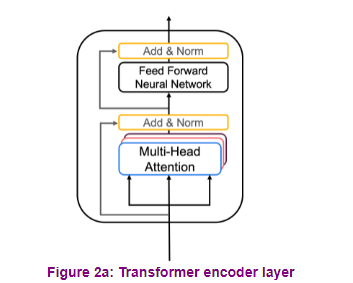

* `MultiHeadAttention` bạn có thể coi như tính toán khả năng tự chú ý nhiều lần để phát hiện các tính năng khác nhau.
* Mạng nơron chuyển tiếp nguồn cấp dữ liệu chứa hai lớp dày đặc mà chúng tôi sẽ triển khai dưới dạng chức năng `FullyConnected`

Đầu tiên, câu đầu vào của bạn chuyển qua * multi-head attention layer *, nơi bộ mã hóa xem xét các từ khác trong câu đầu vào khi nó mã hóa một từ cụ thể. Sau đó, các đầu ra của lớp chú ý nhiều đầu được đưa đến một mạng nơ-ron * feed forward neural network *. Mạng chuyển tiếp nguồn cấp dữ liệu chính xác giống nhau được áp dụng độc lập cho từng vị trí.
   
* Đối với lớp `MultiHeadAttention`, bạn sẽ sử dụng[Keras implementation](https://www.tensorflow.org/api_docs/python/tf/keras/layers/MultiHeadAttention). Nếu bạn tò mò về cách chia ma trận truy vấn Q, ma trận khóa K và ma trận giá trị V thành các đầu khác nhau, bạn có thể xem qua cách triển khai.
* Bạn cũng sẽ sử dụng [API tuần tự](https://keras.io/api/models/sequential/) với hai lớp dày đặc để xây dựng các lớp mạng nơ-ron chuyển tiếp nguồn cấp dữ liệu.

In [ ]:
def FullyConnected(embedding_dim, fully_connected_dim):
    return tf.keras.Sequential([
        tf.keras.layers.Dense(fully_connected_dim, activation='relu'),  # (batch_size, seq_len, dff)
        tf.keras.layers.Dense(embedding_dim)  # (batch_size, seq_len, d_model)
    ])

<a name='4-1'> </a>
### 4.1 Encoder Layer

Giờ đây, bạn có thể ghép nối sự chú ý nhiều đầu và chuyển tiếp mạng nơ-ron chuyển tiếp với nhau trong một lớp mã hóa! Bạn cũng sẽ sử dụng các kết nối dư và chuẩn hóa lớp để giúp tăng tốc quá trình đào tạo (Hình 2a).

<a name='ex-4'> </a>
### Bài tập 4 - EncoderLayer

Triển khai `EncoderLayer ()` bằng phương thức `call ()`

Trong bài tập này, bạn sẽ triển khai một khối mã hóa (Hình 2) bằng phương thức `call ()`. Hàm phải thực hiện các bước sau:
1. Bạn sẽ chuyển các ma trận Q, V, K và mặt nạ boolean vào một lớp chú ý nhiều đầu. Hãy nhớ rằng để tính `self-attention` Q, V và K phải giống nhau.
2. Tiếp theo, bạn sẽ chuyển đầu ra của lớp chú ý nhiều đầu cho một lớp bỏ học. Đừng quên sử dụng tham số `training` để đặt chế độ cho mô hình của bạn.
3. Bây giờ thêm kết nối bỏ qua bằng cách thêm đầu vào ban đầu `x` của bạn và đầu ra của lớp bỏ qua.
4. Sau khi thêm kết nối bỏ qua, chuyển đầu ra qua chuẩn hóa lớp đầu tiên.
5. Cuối cùng, lặp lại các bước từ 1-4 nhưng với mạng nơ-ron chuyển tiếp nguồn cấp dữ liệu thay vì lớp chú ý nhiều đầu.

**Gợi ý bổ sung**:
* Phương thức `__init__` tạo tất cả các lớp sẽ được thêm vào bởi phương thức` call`. Bất cứ nơi nào bạn muốn sử dụng một lớp được xác định bên trong phương thức `__init__`, bạn sẽ phải sử dụng cú pháp` self. [Insert layer name] `.
* Bạn sẽ thấy tài liệu về [MultiHeadAttention](https://www.tensorflow.org/api_docs/python/tf/keras/layers/MultiHeadAttention) hữu ích. 
*Lưu ý rằng nếu truy vấn, khóa và giá trị giống nhau, thì hàm này thực hiện tự chú ý.*

In [ ]:
# UNQ_C4 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
# GRADED FUNCTION EncoderLayer
class EncoderLayer(tf.keras.layers.Layer):
    """
    The encoder layer is composed by a multi-head self-attention mechanism,
    followed by a simple, positionwise fully connected feed-forward network. 
    This archirecture includes a residual connection around each of the two 
    sub-layers, followed by layer normalization.
    """
    def __init__(self, embedding_dim, num_heads, fully_connected_dim, dropout_rate=0.1, layernorm_eps=1e-6):
        super(EncoderLayer, self).__init__()

        self.mha = MultiHeadAttention(num_heads=num_heads,
                                      key_dim=embedding_dim)

        self.ffn = FullyConnected(embedding_dim=embedding_dim,
                                  fully_connected_dim=fully_connected_dim)

        self.layernorm1 = LayerNormalization(epsilon=layernorm_eps)
        self.layernorm2 = LayerNormalization(epsilon=layernorm_eps)

        self.dropout1 = Dropout(dropout_rate)
        self.dropout2 = Dropout(dropout_rate)
    
    def call(self, x, training, mask):
        """
        Forward pass for the Encoder Layer
        
        Arguments:
            x -- Tensor of shape (batch_size, input_seq_len, fully_connected_dim)
            training -- Boolean, set to true to activate
                        the training mode for dropout layers
            mask -- Boolean mask to ensure that the padding is not 
                    treated as part of the input
        Returns:
            out2 -- Tensor of shape (batch_size, input_seq_len, fully_connected_dim)
        """
        # START CODE HERE
        # calculate self-attention using mha(~1 line)
        attn_output = self.mha(x,x,x,mask) # Self attention (batch_size, input_seq_len, fully_connected_dim)
        
        # apply dropout layer to the self-attention output (~1 line)
        attn_output = self.dropout1(attn_output,training=training)
        
        # apply layer normalization on sum of the input and the attention output to get the  
        # output of the multi-head attention layer (~1 line)
        out1 =  self.layernorm1(x+attn_output)  # (batch_size, input_seq_len, fully_connected_dim)

        # pass the output of the multi-head attention layer through a ffn (~1 line)
        ffn_output = self.ffn(out1)  # (batch_size, input_seq_len, fully_connected_dim)
        
        # apply dropout layer to ffn output (~1 line)
        ffn_output = self.dropout2(ffn_output,training=training)
        
        # apply layer normalization on sum of the output from multi-head attention and ffn output to get the
        # output of the encoder layer (~1 line)
        out2 = self.layernorm2(out1+ffn_output)  # (batch_size, input_seq_len, fully_connected_dim)
        # END CODE HERE
        
        return out2

In [ ]:
# UNIT TEST
def EncoderLayer_test(target):
    q = np.array([[[1, 0, 1, 1], [0, 1, 1, 1], [1, 0, 0, 1]]]).astype(np.float32)
    encoder_layer1 = EncoderLayer(4, 2, 8)
    tf.random.set_seed(10)
    encoded = encoder_layer1(q, True, np.array([[1, 0, 1]]))
    
    assert tf.is_tensor(encoded), "Wrong type. Output must be a tensor"
    assert tuple(tf.shape(encoded).numpy()) == (1, q.shape[1], q.shape[2]), f"Wrong shape. We expected ((1, {q.shape[1]}, {q.shape[2]}))"

    assert np.allclose(encoded.numpy(), 
                       [[-0.5214877 , -1.001476  , -0.12321664,  1.6461804 ],
                       [-1.3114998 ,  1.2167752 , -0.5830886 ,  0.6778133 ],
                       [ 0.25485858,  0.3776546 , -1.6564771 ,  1.023964  ]],), "Wrong values"
    
    print("\033[92mAll tests passed")
    

EncoderLayer_test(EncoderLayer)

All tests passed


<a name='4-2'></a>
### 4.2 - Full Encoder
Công việc tuyệt vời! Bây giờ bạn đã triển khai thành công mã hóa vị trí, tự chú ý và một lớp mã hóa - hãy tự giúp mình. Bây giờ bạn đã sẵn sàng xây dựng Bộ mã hóa biến áp đầy đủ (Hình 2b), nơi bạn sẽ nhúng đầu vào của mình và thêm các mã hóa vị trí mà bạn đã tính toán. Sau đó, bạn sẽ cung cấp các bản nhúng được mã hóa của mình vào một chồng các lớp Bộ mã hóa.


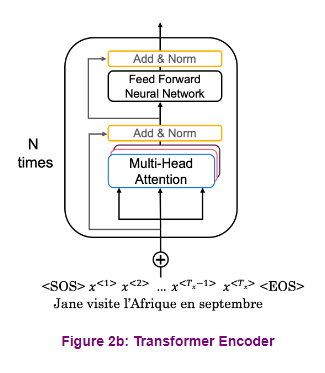

<a name='ex-5'></a>
### Exercise 5 - Encoder
Hoàn thành chức năng `Encoder ()` bằng cách sử dụng phương thức call ()' để nhúng đầu vào của bạn, thêm mã hóa vị trí và triển khai nhiều lớp bộ mã hóa

Trong bài tập này, bạn sẽ khởi tạo Bộ mã hóa của mình bằng một lớp Nhúng, mã hóa vị trí và nhiều Lớp mã hóa. Phương thức `call ()` của bạn sẽ thực hiện các bước sau:
1. Chuyển đầu vào của bạn qua lớp Nhúng.
2. Chia tỷ lệ nhúng của bạn bằng cách nhân nó với căn bậc hai của kích thước nhúng của bạn. Hãy nhớ truyền thứ nguyên nhúng sang kiểu dữ liệu `tf.float32` trước khi tính căn bậc hai.
3. Thêm mã hóa vị trí: self.pos_encoding `[:,: seq_len,:]` vào nhúng của bạn.
4. Chuyển phần nhúng được mã hóa qua một lớp bỏ qua, hãy nhớ sử dụng tham số `training` để đặt chế độ huấn luyện mô hình.
5. Chuyển đầu ra của lớp bỏ qua thông qua chồng lớp mã hóa bằng cách sử dụng vòng lặp for.

In [ ]:
# UNQ_C5 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
# GRADED FUNCTION
class Encoder(tf.keras.layers.Layer):
    """
    The entire Encoder starts by passing the input to an embedding layer 
    and using positional encoding to then pass the output through a stack of
    encoder Layers
        
    """   
    def __init__(self, num_layers, embedding_dim, num_heads, fully_connected_dim, input_vocab_size,
               maximum_position_encoding, dropout_rate=0.1, layernorm_eps=1e-6):
        super(Encoder, self).__init__()

        self.embedding_dim = embedding_dim
        self.num_layers = num_layers

        self.embedding = Embedding(input_vocab_size, self.embedding_dim)
        self.pos_encoding = positional_encoding(maximum_position_encoding, 
                                                self.embedding_dim)


        self.enc_layers = [EncoderLayer(embedding_dim=self.embedding_dim,
                                        num_heads=num_heads,
                                        fully_connected_dim=fully_connected_dim,
                                        dropout_rate=dropout_rate,
                                        layernorm_eps=layernorm_eps) 
                           for _ in range(self.num_layers)]

        self.dropout = Dropout(dropout_rate)
        
    def call(self, x, training, mask):
        """
        Forward pass for the Encoder
        
        Arguments:
            x -- Tensor of shape (batch_size, input_seq_len)
            training -- Boolean, set to true to activate
                        the training mode for dropout layers
            mask -- Boolean mask to ensure that the padding is not 
                    treated as part of the input
        Returns:
            out2 -- Tensor of shape (batch_size, input_seq_len, fully_connected_dim)
        """

        seq_len = tf.shape(x)[1]
        
        # START CODE HERE
        # Pass input through the Embedding layer
        x = self.embedding(x)  # (batch_size, input_seq_len, fully_connected_dim)
        # Scale embedding by multiplying it by the square root of the embedding dimension
        x *= tf.math.sqrt(tf.cast(self.embedding_dim, tf.float32))
        # Add the position encoding to embedding
        x += self.pos_encoding [:,: seq_len,:]
        # Pass the encoded embedding through a dropout layer
        x = self.dropout(x, training=training)
        # Pass the output through the stack of encoding layers 
        for i in range(self.num_layers):
            x =self.enc_layers[i](x,training,mask)
        # END CODE HERE

        return x  # (batch_size, input_seq_len, fully_connected_dim)

In [ ]:
# UNIT TEST
def Encoder_test(target):
    tf.random.set_seed(10)
    
    embedding_dim=4
    
    encoderq = target(num_layers=2,
                      embedding_dim=embedding_dim,
                      num_heads=2,
                      fully_connected_dim=8,
                      input_vocab_size=32,
                      maximum_position_encoding=5)
    
    x = np.array([[2, 1, 3], [1, 2, 0]])
    
    encoderq_output = encoderq(x, True, None)
    
    assert tf.is_tensor(encoderq_output), "Wrong type. Output must be a tensor"
    assert tuple(tf.shape(encoderq_output).numpy()) == (x.shape[0], x.shape[1], embedding_dim), f"Wrong shape. We expected ({eshape[0]}, {eshape[1]}, {embedding_dim})"
    assert np.allclose(encoderq_output.numpy(), 
                       [[[-0.40172306,  0.11519244, -1.2322885,   1.5188192 ],
                         [ 0.4017268,   0.33922842, -1.6836855,   0.9427304 ],
                         [ 0.4685002,  -1.6252842,   0.09368491,  1.063099  ]],
                        [[-0.3489219,   0.31335592, -1.3568854,   1.3924513 ],
                         [-0.08761203, -0.1680029,  -1.2742313,   1.5298463 ],
                         [ 0.2627198,  -1.6140151,   0.2212624 ,  1.130033  ]]]), "Wrong values"
    
    print("\033[92mAll tests passed")
    
Encoder_test(Encoder)

(5, 4)
All tests passed


<a name='5'></a>
## 5 - Decoder
Lớp Bộ giải mã lấy các ma trận K và V do Bộ mã hóa tạo ra và tính toán lớp chú ý nhiều đầu thứ hai với ma trận Q từ đầu ra (Hình 3a).


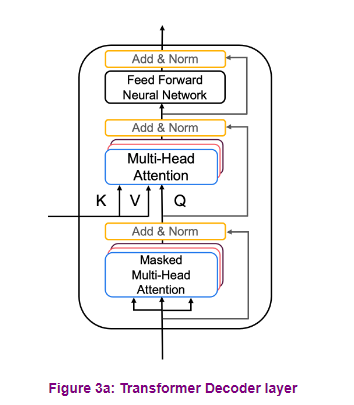

### 5.1 - Lớp giải mã
Một lần nữa, bạn sẽ ghép nối sự chú ý nhiều đầu với một mạng nơ-ron chuyển tiếp, nhưng lần này bạn sẽ triển khai hai lớp sự chú ý nhiều đầu. Bạn cũng sẽ sử dụng các kết nối dư và chuẩn hóa lớp để giúp tăng tốc quá trình đào tạo (Hình 3a).

<a name='ex-6'> </a>
### Bài tập 6 - DecoderLayer
    
Triển khai `DecoderLayer ()` bằng phương thức `call ()`
    
1. Khối 1 là lớp chú ý nhiều đầu với kết nối dư, lớp bỏ học, và mặt nạ nhìn về phía trước.
2. Khối 2 sẽ tính đến đầu ra của Bộ mã hóa, do đó, lớp chú ý nhiều đầu sẽ nhận K và V từ bộ mã hóa và Q từ Khối 1. Sau đó, bạn sẽ áp dụng lớp bỏ qua, chuẩn hóa lớp và phần dư kết nối, giống như bạn đã làm trước đây.
3. Cuối cùng, Khối 3 là một mạng nơ-ron nguồn cấp dữ liệu chuyển tiếp với các lớp bỏ qua và chuẩn hóa và kết nối dư.
    
**Gợi ý bổ sung:**
* Hai khối đầu tiên khá giống với EncoderLayer ngoại trừ bạn sẽ trả về `attention_scores` khi tính toán tự chú ý

In [ ]:
# UNQ_C6 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
# GRADED FUNCTION DecoderLayer
class DecoderLayer(tf.keras.layers.Layer):
    """
    The decoder layer is composed by two multi-head attention blocks, 
    one that takes the new input and uses self-attention, and the other 
    one that combines it with the output of the encoder, followed by a
    fully connected block. 
    """
    def __init__(self, embedding_dim, num_heads, fully_connected_dim, dropout_rate=0.1, layernorm_eps=1e-6):
        super(DecoderLayer, self).__init__()

        self.mha1 = MultiHeadAttention(num_heads=num_heads,
                                      key_dim=embedding_dim)

        self.mha2 = MultiHeadAttention(num_heads=num_heads,
                                      key_dim=embedding_dim)

        self.ffn = FullyConnected(embedding_dim=embedding_dim,
                                  fully_connected_dim=fully_connected_dim)

        self.layernorm1 = LayerNormalization(epsilon=layernorm_eps)
        self.layernorm2 = LayerNormalization(epsilon=layernorm_eps)
        self.layernorm3 = LayerNormalization(epsilon=layernorm_eps)

        self.dropout1 = Dropout(dropout_rate)
        self.dropout2 = Dropout(dropout_rate)
        self.dropout3 = Dropout(dropout_rate)
    
    def call(self, x, enc_output, training, look_ahead_mask, padding_mask):
        """
        Forward pass for the Decoder Layer
        
        Arguments:
            x -- Tensor of shape (batch_size, target_seq_len, fully_connected_dim)
            enc_output --  Tensor of shape(batch_size, input_seq_len, fully_connected_dim)
            training -- Boolean, set to true to activate
                        the training mode for dropout layers
            look_ahead_mask -- Boolean mask for the target_input
            padding_mask -- Boolean mask for the second multihead attention layer
        Returns:
            out3 -- Tensor of shape (batch_size, target_seq_len, fully_connected_dim)
            attn_weights_block1 -- Tensor of shape(batch_size, num_heads, target_seq_len, input_seq_len)
            attn_weights_block2 -- Tensor of shape(batch_size, num_heads, target_seq_len, input_seq_len)
        """
        
        # START CODE HERE
        # enc_output.shape == (batch_size, input_seq_len, fully_connected_dim)
        
        # BLOCK 1
        # calculate self-attention and return attention scores as attn_weights_block1 (~1 line)
        attn1, attn_weights_block1 = self.mha1(x, x, x, look_ahead_mask,return_attention_scores = True)  # (batch_size, target_seq_len, d_model)
        attn1 = self.dropout1(attn1, training=training)
        out1 = self.layernorm1(x+attn1)

        attn2, attn_weights_block2 = self.mha2(out1, enc_output, enc_output, padding_mask, return_attention_scores=True)  # (batch_size, target_seq_len, d_model)
        attn2 = self.dropout2(attn2, training=training)
        out2 = self.layernorm2(out1+attn2)  # (batch_size, target_seq_len, d_model)

        ffn_output = self.ffn(out2)  # (batch_size, target_seq_len, d_model)
        ffn_output = self.dropout3(ffn_output, training=training)
        out3 = self.layernorm3(out2+ffn_output) # (batch_size, target_seq_len, fully_connected_dim)
        # END CODE HERE

        return out3, attn_weights_block1, attn_weights_block2
    

In [ ]:
# UNIT TEST
def DecoderLayer_test(target):
    
    num_heads=8
    tf.random.set_seed(10)
    
    decoderLayerq = target(
        embedding_dim=4, 
        num_heads=num_heads,
        fully_connected_dim=32, 
        dropout_rate=0.1, 
        layernorm_eps=1e-6)
    
    encoderq_output = tf.constant([[[-0.40172306,  0.11519244, -1.2322885,   1.5188192 ],
                                   [ 0.4017268,   0.33922842, -1.6836855,   0.9427304 ],
                                   [ 0.4685002,  -1.6252842,   0.09368491,  1.063099  ]]])
    
    q = np.array([[[1, 0, 1, 1], [0, 1, 1, 1], [1, 0, 0, 1]]]).astype(np.float32)
    
    look_ahead_mask = tf.constant([[0., 1., 1.],
                       [0., 0., 1.],
                       [0., 0., 0.]])
    
    padding_mask = None
    out, attn_w_b1, attn_w_b2 = decoderLayerq(q, encoderq_output, True, look_ahead_mask, padding_mask)
    
    assert tf.is_tensor(attn_w_b1), "Wrong type for attn_w_b1. Output must be a tensor"
    assert tf.is_tensor(attn_w_b2), "Wrong type for attn_w_b2. Output must be a tensor"
    assert tf.is_tensor(out), "Wrong type for out. Output must be a tensor"
    
    shape1 = (q.shape[0], num_heads, q.shape[1], q.shape[1])
    assert tuple(tf.shape(attn_w_b1).numpy()) == shape1, f"Wrong shape. We expected {shape1}"
    assert tuple(tf.shape(attn_w_b2).numpy()) == shape1, f"Wrong shape. We expected {shape1}"
    assert tuple(tf.shape(out).numpy()) == q.shape, f"Wrong shape. We expected {q.shape}"

    assert np.allclose(attn_w_b1[0, 0, 0], [0, 0.5, 0.5], atol=1e-2), "Wrong values in attn_w_b1. Check the call to self.mha1"
    assert np.allclose(attn_w_b2[0, 0, 1], [0.34485385, 0.3323007, 0.32284543]),  "Wrong values in attn_w_b2. Check the call to self.mha2"
    assert np.allclose(out[0, 0], [0.64775777, -1.5134472, 1.1092964, -0.24360701]), "Wrong values in out"
    

    # Now let's try a example with padding mask
    padding_mask = np.array([[0, 0, 1]])
    out, attn_w_b1, attn_w_b2 = decoderLayerq(q, encoderq_output, True, look_ahead_mask, padding_mask)

    assert np.allclose(out[0, 0], [0.59296525, -1.4068702, 1.224841, -0.410936]), "Wrong values in out when we mask the last word. Are you passing the padding_mask to the inner functions?"

    print("\033[92mAll tests passed")
    
DecoderLayer_test(DecoderLayer)

All tests passed


<a name='5-2'> </a>
### 5.2 - Bộ giải mã đầy đủ
Bạn đã gần tới! Đã đến lúc sử dụng lớp Bộ giải mã của bạn để xây dựng Bộ giải mã biến áp đầy đủ (Hình 3b). Bạn sẽ nhúng đầu ra của mình và thêm các mã hóa vị trí. Sau đó, bạn sẽ cung cấp các bản nhúng được mã hóa của mình vào một chồng các lớp Bộ giải mã.


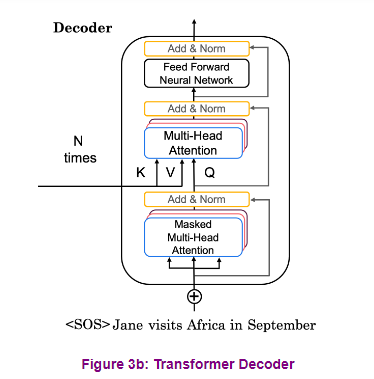

<a name='ex-7'> </a>
### Bài tập 7 - Bộ giải mã

Triển khai `Bộ giải mã ()` bằng cách sử dụng phương thức `call()`để nhúng đầu ra của bạn, thêm mã hóa vị trí và triển khai nhiều lớp bộ giải mã
 
Trong bài tập này, bạn sẽ khởi tạo Bộ giải mã của mình với một lớp Nhúng, mã hóa vị trí và nhiều Lớp giải mã. Phương thức `call ()` của bạn sẽ thực hiện các bước sau:
1. Chuyển đầu ra đã tạo của bạn qua lớp Nhúng.
2. Chia tỷ lệ nhúng của bạn bằng cách nhân nó với căn bậc hai của kích thước nhúng của bạn. Hãy nhớ truyền thứ nguyên nhúng sang kiểu dữ liệu `tf.float32` trước khi tính căn bậc hai.
3. Thêm mã hóa vị trí: self.pos_encoding `[:,: seq_len,:]` vào nhúng của bạn.
4. Chuyển phần nhúng được mã hóa qua một lớp bỏ qua, hãy nhớ sử dụng tham số `training` để đặt chế độ huấn luyện mô hình.
5. Chuyển đầu ra của lớp bỏ qua thông qua chồng các lớp Giải mã bằng cách sử dụng vòng lặp for.

In [ ]:
# UNQ_C7 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
# GRADED FUNCTION Decoder
class Decoder(tf.keras.layers.Layer):
    """
    The entire Encoder is starts by passing the target input to an embedding layer 
    and using positional encoding to then pass the output through a stack of
    decoder Layers
        
    """ 
    def __init__(self, num_layers, embedding_dim, num_heads, fully_connected_dim, target_vocab_size,
               maximum_position_encoding, dropout_rate=0.1, layernorm_eps=1e-6):
        super(Decoder, self).__init__()

        self.embedding_dim = embedding_dim
        self.num_layers = num_layers

        self.embedding = Embedding(target_vocab_size, self.embedding_dim)
        self.pos_encoding = positional_encoding(maximum_position_encoding, self.embedding_dim)

        self.dec_layers = [DecoderLayer(embedding_dim=self.embedding_dim,
                                        num_heads=num_heads,
                                        fully_connected_dim=fully_connected_dim,
                                        dropout_rate=dropout_rate,
                                        layernorm_eps=layernorm_eps) 
                           for _ in range(self.num_layers)]
        self.dropout = Dropout(dropout_rate)
    
    def call(self, x, enc_output, training, 
           look_ahead_mask, padding_mask):
        """
        Forward  pass for the Decoder
        
        Arguments:
            x -- Tensor of shape (batch_size, target_seq_len, fully_connected_dim)
            enc_output --  Tensor of shape(batch_size, input_seq_len, fully_connected_dim)
            training -- Boolean, set to true to activate
                        the training mode for dropout layers
            look_ahead_mask -- Boolean mask for the target_input
            padding_mask -- Boolean mask for the second multihead attention layer
        Returns:
            x -- Tensor of shape (batch_size, target_seq_len, fully_connected_dim)
            attention_weights - Dictionary of tensors containing all the attention weights
                                each of shape Tensor of shape (batch_size, num_heads, target_seq_len, input_seq_len)
        """

        seq_len = tf.shape(x)[1]
        attention_weights = {}
        
        # START CODE HERE
        # create word embeddings 
        x = self.embedding(x)  # (batch_size, target_seq_len, fully_connected_dim)
        
        # scale embeddings by multiplying by the square root of their dimension
        x *= tf.math.sqrt(tf.cast(self.embedding_dim, tf.float32))
        
        # calculate positional encodings and add to word embedding
        x += self.pos_encoding [:,: seq_len,:]
        
        # apply a dropout layer to x
        x = self.dropout(x, training=training)

        # use a for loop to pass x through a stack of decoder layers and update attention_weights (~4 lines total)
        for i in range(self.num_layers):
            # pass x and the encoder output through a stack of decoder layers and save the attention weights
            # of block 1 and 2 (~1 line)
            x, block1, block2 = self.dec_layers[i](x, enc_output, training,
            look_ahead_mask, padding_mask)

            #update attention_weights dictionary with the attention weights of block 1 and block 2
            attention_weights['decoder_layer{}_block1_self_att'.format(i+1)] = block1
            attention_weights['decoder_layer{}_block2_decenc_att'.format(i+1)] = block2
        # END CODE HERE
        
        # x.shape == (batch_size, target_seq_len, fully_connected_dim)
        return x, attention_weights

In [ ]:
# UNIT TEST
def Decoder_test(target):
    
    tf.random.set_seed(10)
        
    num_layers=7
    embedding_dim=4 
    num_heads=3
    fully_connected_dim=8
    target_vocab_size=33
    maximum_position_encoding=6
    
    x = np.array([[3, 2, 1], [2, 1, 0]])

    
    encoderq_output = tf.constant([[[-0.40172306,  0.11519244, -1.2322885,   1.5188192 ],
                         [ 0.4017268,   0.33922842, -1.6836855,   0.9427304 ],
                         [ 0.4685002,  -1.6252842,   0.09368491,  1.063099  ]],
                        [[-0.3489219,   0.31335592, -1.3568854,   1.3924513 ],
                         [-0.08761203, -0.1680029,  -1.2742313,   1.5298463 ],
                         [ 0.2627198,  -1.6140151,   0.2212624 ,  1.130033  ]]])
    
    look_ahead_mask = tf.constant([[0., 1., 1.],
                       [0., 0., 1.],
                       [0., 0., 0.]])
    
    decoderk = Decoder(num_layers,
                    embedding_dim, 
                    num_heads, 
                    fully_connected_dim,
                    target_vocab_size,
                    maximum_position_encoding)
    outd, att_weights = decoderk(x, encoderq_output, False, look_ahead_mask, None)
    
    assert tf.is_tensor(outd), "Wrong type for outd. It must be a dict"
    assert np.allclose(tf.shape(outd), tf.shape(encoderq_output)), f"Wrong shape. We expected { tf.shape(encoderq_output)}"
    assert np.allclose(outd[1, 1], [-0.26879537, -0.9024167, -0.51610225, 1.6873143]), "Wrong values in outd"
    
    keys = list(att_weights.keys())
    assert type(att_weights) == dict, "Wrong type for att_weights[0]. Output must be a tensor"
    assert len(keys) == 2 * num_layers, f"Wrong length for attention weights. It must be 2 x num_layers = {2*num_layers}"
    assert tf.is_tensor(att_weights[keys[0]]), f"Wrong type for att_weights[{keys[0]}]. Output must be a tensor"
    shape1 = (x.shape[0], num_heads, x.shape[1], x.shape[1])
    assert tuple(tf.shape(att_weights[keys[1]]).numpy()) == shape1, f"Wrong shape. We expected {shape1}" 
    assert np.allclose(att_weights[keys[0]][0, 0, 1], [0., 0., 1.]), f"Wrong values in att_weights[{keys[0]}]"
    
    print(outd)

    print("\033[92mAll tests passed")
    
Decoder_test(Decoder)

(6, 4)
tf.Tensor(
[[[-0.76977366 -0.06880033 -0.81584656  1.6544206 ]
  [-0.32420844 -0.88087505 -0.49126652  1.69635   ]
  [-0.22140321 -1.2543879  -0.0647597   1.5405505 ]]

 [[-0.7870081   0.09043872 -0.90268147  1.5992506 ]
  [-0.26879543 -0.9024167  -0.5161022   1.6873145 ]
  [-0.1728644  -1.2476261  -0.12780294  1.5482932 ]]], shape=(2, 3, 4), dtype=float32)
All tests passed


<a name='6'> </a>
## 6 - Máy biến áp

Phù! Đây là một bài tập khá tốt, và bây giờ bạn đã hoàn thành bài tập cuối cùng của mình về Chuyên ngành học sâu. Xin chúc mừng! Bạn đã làm tất cả công việc khó khăn, bây giờ là lúc để kết hợp tất cả lại với nhau.


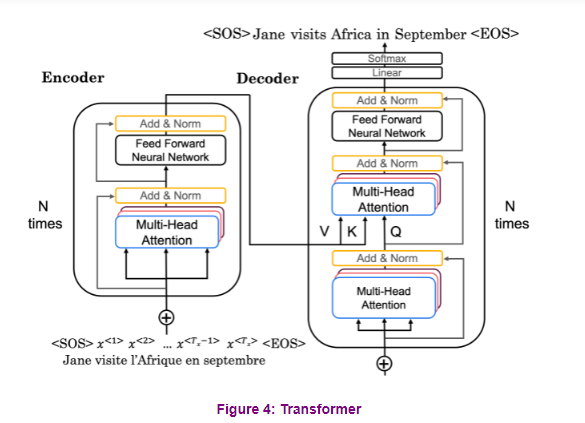

Luồng dữ liệu thông qua Kiến trúc máy biến áp như sau:
* Đầu tiên đầu vào của bạn đi qua Bộ mã hóa, chỉ là các lớp Bộ mã hóa lặp lại mà bạn đã triển khai:
    - nhúng và mã hóa vị trí đầu vào của bạn
    - sự chú ý của nhiều người vào đầu vào của bạn
    - chuyển tiếp mạng nơ-ron để giúp phát hiện các tính năng
* Sau đó, đầu ra dự đoán chuyển qua Bộ giải mã, bao gồm các lớp bộ giải mã mà bạn đã triển khai:
    - nhúng và mã hóa vị trí của đầu ra
    - sự chú ý từ nhiều phía trên đầu ra đã tạo của bạn
    - chú ý nhiều đầu với Q từ lớp chú ý nhiều đầu đầu tiên và K và V từ Bộ mã hóa
    - mạng nơ-ron chuyển tiếp nguồn cấp dữ liệu để giúp phát hiện các tính năng
* Cuối cùng, sau lớp Bộ giải mã thứ N, hai lớp dày đặc và một softmax được áp dụng để tạo dự đoán cho đầu ra tiếp theo trong trình tự của bạn.

<a name='ex-8'> </a>
### Bài tập 8 - Máy biến áp

Triển khai `Transformer ()` bằng phương thức `call ()`
1. Chuyển đầu vào qua Bộ mã hóa với mặt nạ phù hợp.
2. Chuyển đầu ra bộ mã hóa và mục tiêu qua Bộ giải mã với mặt nạ phù hợp.
3. Áp dụng một phép biến đổi tuyến tính và một softmax để có được một dự đoán.

In [ ]:
# UNQ_C8 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
# GRADED FUNCTION Transformer
class Transformer(tf.keras.Model):
    """
    Complete transformer with an Encoder and a Decoder
    """
    def __init__(self, num_layers, embedding_dim, num_heads, fully_connected_dim, input_vocab_size, 
               target_vocab_size, max_positional_encoding_input,
               max_positional_encoding_target, dropout_rate=0.1, layernorm_eps=1e-6):
        super(Transformer, self).__init__()

        self.encoder = Encoder(num_layers=num_layers,
                               embedding_dim=embedding_dim,
                               num_heads=num_heads,
                               fully_connected_dim=fully_connected_dim,
                               input_vocab_size=input_vocab_size,
                               maximum_position_encoding=max_positional_encoding_input,
                               dropout_rate=dropout_rate,
                               layernorm_eps=layernorm_eps)

        self.decoder = Decoder(num_layers=num_layers, 
                               embedding_dim=embedding_dim,
                               num_heads=num_heads,
                               fully_connected_dim=fully_connected_dim,
                               target_vocab_size=target_vocab_size, 
                               maximum_position_encoding=max_positional_encoding_target,
                               dropout_rate=dropout_rate,
                               layernorm_eps=layernorm_eps)

        self.final_layer = Dense(target_vocab_size, activation='softmax')
    
    def call(self, inp, tar, training, enc_padding_mask, look_ahead_mask, dec_padding_mask):
        """
        Forward pass for the entire Transformer
        Arguments:
            inp -- Tensor of shape (batch_size, input_seq_len, fully_connected_dim)
            tar -- Tensor of shape (batch_size, target_seq_len, fully_connected_dim)
            training -- Boolean, set to true to activate
                        the training mode for dropout layers
            enc_padding_mask -- Boolean mask to ensure that the padding is not 
                    treated as part of the input
            look_ahead_mask -- Boolean mask for the target_input
            padding_mask -- Boolean mask for the second multihead attention layer
        Returns:
            final_output -- Describe me
            attention_weights - Dictionary of tensors containing all the attention weights for the decoder
                                each of shape Tensor of shape (batch_size, num_heads, target_seq_len, input_seq_len)
        
        """
        # START CODE HERE
        # call self.encoder with the appropriate arguments to get the encoder output
        enc_output = self.encoder(inp, training, enc_padding_mask) # (batch_size, inp_seq_len, fully_connected_dim)
        
        # call self.decoder with the appropriate arguments to get the decoder output
        # dec_output.shape == (batch_size, tar_seq_len, fully_connected_dim)
        dec_output, attention_weights = self.decoder(tar, enc_output, training, look_ahead_mask, dec_padding_mask)
        
        # pass decoder output through a linear layer and softmax (~2 lines)
        final_output = self.final_layer(dec_output)  # (batch_size, tar_seq_len, target_vocab_size)
        # START CODE HERE

        return final_output, attention_weights

In [ ]:
# UNIT TEST
def Transformer_test(target):
    
    tf.random.set_seed(10)


    num_layers = 6
    embedding_dim = 4
    num_heads = 4
    fully_connected_dim = 8
    input_vocab_size = 30
    target_vocab_size = 35
    max_positional_encoding_input = 5
    max_positional_encoding_target = 6

    trans = Transformer(num_layers, 
                        embedding_dim, 
                        num_heads, 
                        fully_connected_dim, 
                        input_vocab_size, 
                        target_vocab_size, 
                        max_positional_encoding_input,
                        max_positional_encoding_target)
    # 0 is the padding value
    sentence_lang_a = np.array([[2, 1, 4, 3, 0]])
    sentence_lang_b = np.array([[3, 2, 1, 0, 0]])

    enc_padding_mask = np.array([[0, 0, 0, 0, 1]])
    dec_padding_mask = np.array([[0, 0, 0, 1, 1]])

    look_ahead_mask = create_look_ahead_mask(sentence_lang_a.shape[1])

    translation, weights = trans(
        sentence_lang_a,
        sentence_lang_b,
        True,
        enc_padding_mask,
        look_ahead_mask,
        dec_padding_mask
    )
    
    
    assert tf.is_tensor(translation), "Wrong type for translation. Output must be a tensor"
    shape1 = (sentence_lang_a.shape[0], max_positional_encoding_input, target_vocab_size)
    assert tuple(tf.shape(translation).numpy()) == shape1, f"Wrong shape. We expected {shape1}"
        
    assert np.allclose(translation[0, 0, 0:8],
                       [[0.02664799, 0.02222014, 0.01641812, 0.02407483,
                         0.04251551, 0.02240461, 0.01556584, 0.03741234]]), "Wrong values in outd"
    
    keys = list(weights.keys())
    assert type(weights) == dict, "Wrong type for weights. It must be a dict"
    assert len(keys) == 2 * num_layers, f"Wrong length for attention weights. It must be 2 x num_layers = {2*num_layers}"
    assert tf.is_tensor(weights[keys[0]]), f"Wrong type for att_weights[{keys[0]}]. Output must be a tensor"
   
    shape1 = (sentence_lang_a.shape[0], num_heads, sentence_lang_a.shape[1], sentence_lang_a.shape[1])
    assert tuple(tf.shape(weights[keys[1]]).numpy()) == shape1, f"Wrong shape. We expected {shape1}" 
    assert np.allclose(weights[keys[0]][0, 0, 1], [0., 0., 0.31332517, 0.33401096, 0.35266393]), f"Wrong values in weights[{keys[0]}]"
    
    print(translation)
    
    print("\033[92mAll tests passed")

    
Transformer_test(Transformer)

(5, 4)
(6, 4)
tf.Tensor(
[[[0.02664799 0.02222014 0.01641811 0.02407483 0.04251551 0.02240461
   0.01556584 0.03741234 0.02219474 0.03070304 0.01657771 0.02320538
   0.05626804 0.02475978 0.0123153  0.03445699 0.02489157 0.01710641
   0.0285781  0.02612221 0.04457929 0.0646245  0.03617345 0.02878232
   0.05089145 0.01346405 0.01689718 0.01745735 0.0263164  0.01547109
   0.06246088 0.02078968 0.02992702 0.02976683 0.01795984]
  [0.02563448 0.01814869 0.01746106 0.02871587 0.04842261 0.02018655
   0.01510809 0.03420014 0.02911283 0.0263037  0.01861953 0.01856346
   0.05862116 0.03152708 0.01407297 0.0289818  0.02613836 0.01670242
   0.02511083 0.02338199 0.04110781 0.05773082 0.0364884  0.03320226
   0.04664034 0.01668854 0.01446597 0.01922656 0.02358109 0.01780589
   0.06111281 0.02174804 0.03137394 0.03342703 0.02038689]
  [0.02149042 0.01378212 0.02102066 0.03669505 0.05874295 0.01929306
   0.01660621 0.03171067 0.04481477 0.0251395  0.01826587 0.01311661
   0.0591367  0.03955816 0.01

## Phần kết luận

Bạn đã đi đến cuối phần được chấm điểm của bài tập. Bây giờ, bạn đã:

* Tạo mã hóa vị trí để nắm bắt các mối quan hệ tuần tự trong dữ liệu
* Tính toán sự tự chú ý của sản phẩm chấm theo tỷ lệ bằng cách nhúng từ
* Thực hiện sự chú ý nhiều đầu có mặt nạ
* Xây dựng và đào tạo mô hình Máy biến áp

<font color = 'blue'>
     <b> Những gì bạn nên nhớ </b>:

- Sự kết hợp giữa tự chú ý và các lớp mạng phức hợp cho phép song song đào tạo và *đào tạo nhanh hơn*.
- Sự chú ý của bản thân được tính bằng cách sử dụng truy vấn Q, khóa K và ma trận giá trị V được tạo.
- Thêm mã hóa vị trí vào nhúng từ là một cách hiệu quả để đưa thông tin trình tự vào các phép tính tự chú ý.
- Chú ý nhiều đầu có thể giúp phát hiện nhiều đặc điểm trong câu của bạn.
- Che dấu ngăn không cho mô hình 'nhìn về phía trước' trong quá trình đào tạo hoặc đặt trọng số 0 quá nhiều khi xử lý các câu đã cắt.

Bây giờ bạn đã hoàn thành nhiệm vụ Máy biến áp, hãy đảm bảo bạn kiểm tra các phòng thí nghiệm chưa được phân loại để áp dụng mô hình Máy biến áp cho các trường hợp sử dụng thực tế như Nhận dạng đối tượng tên (NER) và Trả lời câu hỏi (QA).


# Chúc mừng bạn đã hoàn thành Chuyên ngành Học sâu !!!!!! 🎉

Đây là bài tập được xếp loại cuối cùng của chuyên ngành. Bây giờ là lúc để kỷ niệm tất cả công việc khó khăn và cống hiến của bạn!

<a name='7'> </a>
## 7 - Tài liệu tham khảo

Thuật toán Transformer do Vaswani et al. (2017).

- Ashish Vaswani, Noam Shazeer, Niki Parmar, Jakob Uszkoreit, Llion Jones, Aidan N. Gomez, Lukasz Kaiser, Illia Polosukhin (2017). [Sự chú ý là tất cả những gì bạn cần](https://arxiv.org/abs/1706.03762)